In [230]:
import numpy as np
import matplotlib.pyplot as plt

# define the two test functions
def rosenbrock(x, y):
    """
    Rosenbrock function: f(x, y) = 100(x^2 - y)^2 + (1 - x)^2
    It is banana-shaped graph with a global minimum at (1, 1) where the value is 0.
    """
    return 100 * (x**2 - y)**2 + (1 - x)**2

def griewank(x, y):
    """
    Griewank function: f(x, y) = 1 + (x^2 + y^2)/4000 - cos(x)cos(y/sqrt(2))
    This has lots of local minima, but the global minimum is at (0, 0) with value 0.
    """
    return 1 + (x**2 + y**2) / 4000 - np.cos(x) * np.cos(y / np.sqrt(2))

In [241]:
#class to handle PSO optimization
class ParticleSwarmOptimizer:
    def __init__(self, objective_func, bounds, num_particles=60, max_iter=200,
                 omega_start=1.0, omega_end=0.4, c1=0.25, c2=0.99):
        """
        setupPSO optimizer with all the parameters we need.

        Args:
            objective_func: The function we're trying to minimize (rosenbrock or griewank).
            bounds: The [lower, upper] bounds for x, y coordinates.
            num_particles: How many particles we want in our swarm - 60
            max_iter: Max iterations to run - 200 iterations were enough to converge(from graphs)
            omega_start, omega_end: Inertia weight range - starts high for exploration, ends low for fine-tuning.
            c1, c2: Learning factors for personal and social components
        """
        self.objective_func = objective_func
        self.bounds = bounds
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.omega_start = omega_start
        self.omega_end = omega_end
        self.c1 = c1
        self.c2 = c2
        self.dim = 2  # working in 2D (x, y) for this problem

        #initialize swarm attributes
        self.positions = None
        self.velocities = None
        self.pbest_positions = None
        self.pbest_values = None
        self.gbest_position = None
        self.gbest_value = None
        self.best_so_far = []
        self.avg_so_far = []

    def initialize_swarm(self):
        """
        set up swarm with random positions and velocities
        """
        lb, ub = self.bounds
        # generate random positions within bounds for all particles
        self.positions = np.random.uniform(lb, ub, (self.num_particles, self.dim))
        self.velocities = np.zeros((self.num_particles, self.dim))  # Start with zero velocity
        self.pbest_positions = self.positions.copy()  # pb start at initial positions
        #compute fitness for each particle's initial position
        self.pbest_values = np.array([self.objective_func(p[0], p[1]) for p in self.positions])
        # Find the global best among the initial positions
        gbest_idx = np.argmin(self.pbest_values)
        self.gbest_position = self.pbest_positions[gbest_idx].copy()
        self.gbest_value = self.pbest_values[gbest_idx]
        #track metrics for plotting
        self.best_so_far = [self.gbest_value]
        self.avg_so_far = [np.mean(self.pbest_values)]

    def optimize(self):
        """
        run the PSO optimization loop
        update velocities and positions, and keep track of best solutions.
        """
        self.initialize_swarm()  # set up the swarm

        # loop through iterations
        for iteration in range(self.max_iter):
            # Dynamic inertia weight - start high for exploration, end low for fine-tuning
            omega = self.omega_start - (self.omega_start - self.omega_end) * (iteration / self.max_iter)
            # Random factors for the cognitive and social components
            r1, r2 = np.random.rand(self.num_particles, self.dim), np.random.rand(self.num_particles, self.dim)
            # Compute the cognitive pull (towards pb)
            cognitive = self.c1 * r1 * (self.pbest_positions - self.positions)
            # Compute the social pull (towards gb)
            social = self.c2 * r2 * (self.gbest_position - self.positions)
            # Update velocities using the PSO formula
            self.velocities = omega * self.velocities + cognitive + social
            # Update positions by adding velocities
            self.positions = self.positions + self.velocities
            self.positions = np.clip(self.positions, self.bounds[0], self.bounds[1])  # stay within bounds

            # evaluate the fitness for all particles at their new positions
            fitness_values = np.array([self.objective_func(p[0], p[1]) for p in self.positions])
            # Update pb if we found better positions
            improved = fitness_values < self.pbest_values
            self.pbest_positions[improved] = self.positions[improved]
            self.pbest_values[improved] = fitness_values[improved]

            # check if found a new gb
            curr_best_idx = np.argmin(self.pbest_values)
            if self.pbest_values[curr_best_idx] < self.gbest_value:
                self.gbest_value = self.pbest_values[curr_best_idx]
                self.gbest_position = self.pbest_positions[curr_best_idx].copy()

            # track metrics for plotting
            self.best_so_far.append(self.gbest_value)
            self.avg_so_far.append(np.mean(fitness_values))

        # Return the best solution found
        return self.gbest_position, self.gbest_value, self.best_so_far, self.avg_so_far

In [ ]:
# Plotting function for best-so-far and avg-so-far
def plot_results(best_so_far, avg_so_far, title):
    """
    Plot best-so-far and avg-so-far fitness values per iteration.

    Args:
        best_so_far: List of best fitness values per iteration.
        avg_so_far: List of average fitness values per iteration.
        title: Plot title.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(best_so_far, label="Best-so-far")
    plt.plot(avg_so_far, label="Avg-so-far")
    plt.xlabel("Iteration")
    plt.ylabel("Fitness Value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

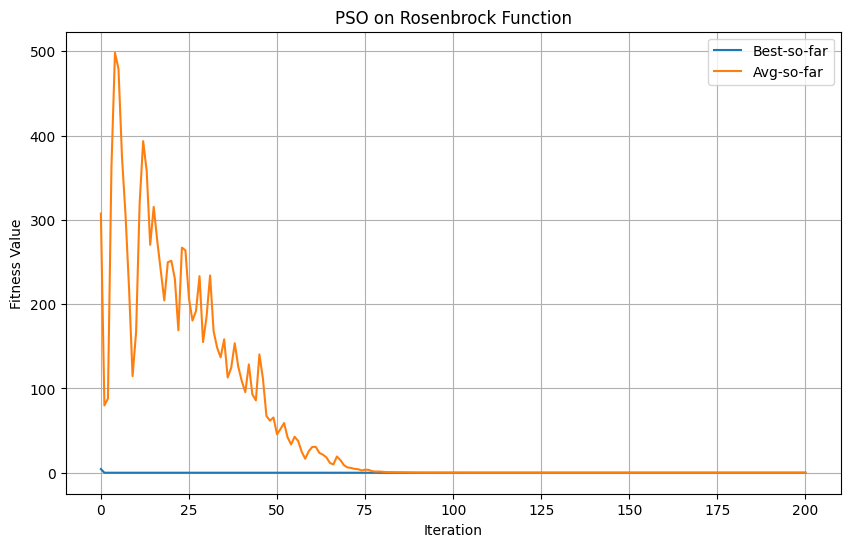

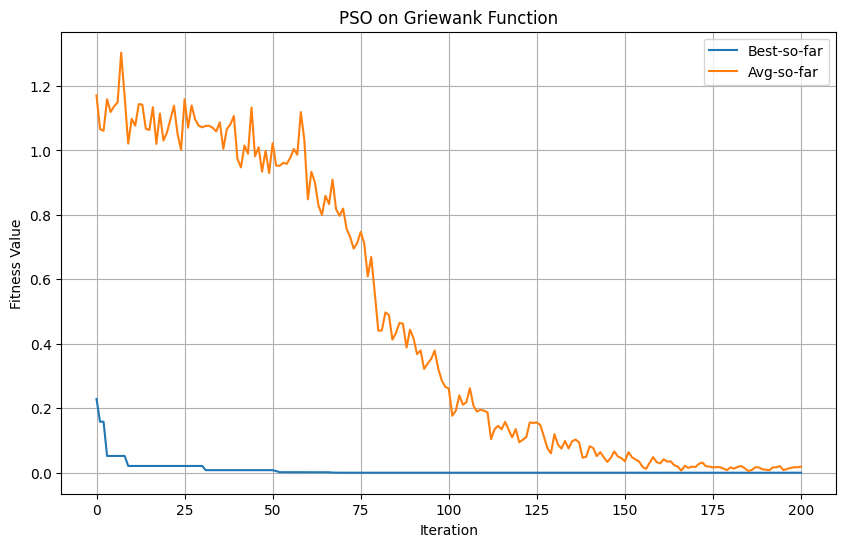

Rosenbrock Function:
Global Minimum at (x, y) = (1.0000, 1.0000)
Minimum Value = 0.0000

Griewank Function:
Global Minimum at (x, y) = (-0.0000, -0.0000)
Minimum Value = 0.0000


In [ ]:
# run PSO for Rosenbrock
bounds_rosen = np.array([[-2, -1], [2, 3]])  # Bounds for Rosenbrock
pso_rosen = ParticleSwarmOptimizer(rosenbrock, bounds_rosen)
pos_rosen, val_rosen, best_rosen, avg_rosen = pso_rosen.optimize()

# run PSO for Griewank
bounds_griew = np.array([[-30, -30], [30, 30]])  # Bounds for Griewank
pso_griew = ParticleSwarmOptimizer(griewank, bounds_griew)
pos_griew, val_griew, best_griew, avg_griew = pso_griew.optimize()

# plot results
plot_results(best_rosen, avg_rosen, "PSO on Rosenbrock Function")
plot_results(best_griew, avg_griew, "PSO on Griewank Function")

# final results
print("Rosenbrock Function:")
print(f"Global Minimum at (x, y) = ({pos_rosen[0]:.4f}, {pos_rosen[1]:.4f})")
print(f"Minimum Value = {val_rosen:.4f}")

print("\nGriewank Function:")
print(f"Global Minimum at (x, y) = ({pos_griew[0]:.4f}, {pos_griew[1]:.4f})")
print(f"Minimum Value = {val_griew:.4f}")